In [1]:
import re
import os
from operator import itemgetter
import sys

sys.path.append('/home/1/dev/proj/dugseis/devel/processing/analysis/')

import pandas as pd
from obspy import UTCDateTime

import ds_picker_histogram

## Setup Reference Data

In [2]:
src = '/mnt/da/tmp/dug-seis/src/Gmug/s-wave/Foci_Picks_Tabelle1_HP5000_pickDaniel.txt'
events = []

with open(src, 'r') as fh:
    lines = fh.read().strip().split('\n')

# 1128 events
for idx in range(len(lines)):
    line = lines[idx].strip()
    if idx % 3 == 0:
        parts = line.replace('.fsf', '').split('_')
        events.append({
            'idx'  : int(idx / 3),
            'id'   : parts[0],
            'name' : parts[1],
            'num'  : parts[2],
        })
    elif idx % 3 == 1:
        events[-1]['p'] = [int(t) for t in line.split()[0:12]]
    else:
        events[-1]['s'] = [int(t) for t in line.split()[0:12]]

In [3]:
print(f'{len(events)} events')

1128 events


In [4]:
# Kann es sein, dass ein Event bei 0 liegt? – Eigentlich nicht.
non_events = [e for e in events if sum(e['p']) == 0 and sum(e['s']) == 0]
len(non_events)

503

Es gibt in der Datei <code>Foci_Picks_Tabelle1_HP5000_pickDaniel.txt</code> keine Möglichkeit,  
die Anfangszeit eines Events festzustellen, außer dem ersten. Deshalb werden diese von den  
Namen der H5-Dateien geholt.

In [5]:
dir = '/home/1/dev/proj/dugseis/devel/processing/s-wave/ASDF'
times = [x[:-9] for x in sorted(os.listdir(dir))[:-1]]
times_str = [re.sub('(..)-(..)-(..)(....)$', r'\1:\2:\3.\4', t) for t in times]
times_utc = [UTCDateTime(t) for t in times_str]

times_str[0:5]

['2015-03-25T00:14:49.4000',
 '2015-03-25T00:16:33.2470',
 '2015-03-25T00:25:06.2480',
 '2015-03-25T00:43:14.4940',
 '2015-03-25T00:51:31.8030']

In [6]:
def format_name(s):
    return re.sub('(....)(..)(..)(..)(..)(..)(.*)', r'\1-\2-\3T\4:\5:\6.\7', s[3:])

def utc_of_list(col):
    def func(row):
        return [(row['starttime'] + x / 500_0400 if x != 0 else None) for x in row[col]]
    return func

ref = pd.DataFrame(events)
ref.sort_values(by=['name', 'num'], inplace=True)

ref.insert(3, column='starttime_str', value=times_str)
ref.insert(4, column='starttime', value=times_utc)
# ref.iloc[:1, :]

In [7]:
ref.insert(ref.columns.get_loc('p') + 1, column='p_times', value=None)
ref['p_times'] = ref.apply(utc_of_list('p'), axis=1)

ref.insert(ref.columns.get_loc('s') + 1, column='s_times', value=None)
ref['s_times'] = ref.apply(utc_of_list('s'), axis=1)
# ref.iloc[:1, :]

In [8]:
ref.loc[:, ['starttime_str', 'p_times', 's_times']].iloc[:5, :]
ref2 = ref.loc[:, ['starttime_str', 'p_times', 's_times']]
ref2.iloc[:5, :]

,starttime_str,p_times,s_times
856,2015-03-25T00:14:49.4000,"[2015-03-25T00:14:49.400681Z, 2015-03-25T00:14...","[2015-03-25T00:14:49.400772Z, 2015-03-25T00:14..."
103,2015-03-25T00:16:33.2470,"[2015-03-25T00:16:33.247993Z, 2015-03-25T00:16...","[None, 2015-03-25T00:16:33.247579Z, 2015-03-25..."
68,2015-03-25T00:25:06.2480,"[2015-03-25T00:25:06.249003Z, 2015-03-25T00:25...","[2015-03-25T00:25:06.249187Z, 2015-03-25T00:25..."
131,2015-03-25T00:43:14.4940,"[2015-03-25T00:43:14.495039Z, 2015-03-25T00:43...","[None, 2015-03-25T00:43:14.494714Z, 2015-03-25..."
394,2015-03-25T00:51:31.8030,"[2015-03-25T00:51:31.803644Z, 2015-03-25T00:51...","[2015-03-25T00:51:31.803918Z, 2015-03-25T00:51..."


## Import DUG-Seis Picks

In [9]:
def fill_gaps(li, length):
    di = {k: None for k in range(length)}
    # create empty dict
    for el in li:
        di[int(el[0] - 1)] = el[1]
    # create list
    return [di[key] for key in sorted(di.keys())]


def parse_pick_data_times(file):
    with open(file, 'r') as fh:
        lines = fh.read().strip().split('\n')
    picks = []
    for line in lines:
        parts = line.split('%')
        pick = {'starttime_str': re.sub('T(..)-(..)-(..)(....)Z.*', r'T\1:\2:\3.\4', parts[0])}

        parts = parts[1].split('$')

        parts = parts[1].split(';')
        pick['picks'] = [p.split(',') for p in parts]
        if parts == ['']:
            pick['picks'] = []
        else:
            for p in pick['picks']:
                p[0] = int(p[0])
                p[1] = UTCDateTime(p[1])

        pick['picks'] = fill_gaps(pick['picks'], 12)
        picks.append(pick)
    return picks

In [10]:
thr_on_str = '11'
file = f'/mnt/da/tmp/dug-seis/analysis/gmug/12_ch/thr_on_{thr_on_str}/picks_s.csv'

In [11]:
dug_pp = parse_pick_data_times(file)
dug_pp = pd.DataFrame(dug_pp)
# Test auf Doubletten bei starttime_str
len(dug_pp[dug_pp.duplicated('starttime_str', keep=False)])

0

In [12]:
def count_picks(row):
    return len([x for x in row['picks'] if x is not None])

dug_pp['picks_count'] = dug_pp.apply(count_picks, axis=1)

In [13]:
# dug_pp.iloc[1, 1]
# len(dug_pp)
dug_pp[0:10]
print(len(dug_pp))
statistic = {}
for i in range(13):
    statistic[i] = len(dug_pp[dug_pp['picks_count'] == i])
# print(len(dug_pp[dug_pp['picks_count'] == 0]))
statistic

1127


{0: 599,
 1: 325,
 2: 115,
 3: 53,
 4: 19,
 5: 12,
 6: 2,
 7: 2,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0}

In [14]:
merged = ref2.merge(dug_pp, on='starttime_str', how='outer', indicator=True)
merged.iloc[:50, :]
len(merged[merged._merge == 'both'])
len(merged[merged._merge == 'left_only'])
merged[merged._merge == 'left_only']

,starttime_str,p_times,s_times,picks,picks_count,_merge
13,2015-03-25T01:18:58.0580,"[2015-03-25T01:18:58.060294Z, 2015-03-25T01:18...","[None, None, None, None, None, None, 2015-03-2...",NaN,NaN,left_only


In [15]:
merged = ref2.merge(dug_pp, on='starttime_str', how='inner')
len(merged)

1127

In [16]:
merged.iloc[:10, :]

,starttime_str,p_times,s_times,picks,picks_count
0,2015-03-25T00:14:49.4000,"[2015-03-25T00:14:49.400681Z, 2015-03-25T00:14...","[2015-03-25T00:14:49.400772Z, 2015-03-25T00:14...","[None, None, None, None, None, None, None, Non...",0
1,2015-03-25T00:16:33.2470,"[2015-03-25T00:16:33.247993Z, 2015-03-25T00:16...","[None, 2015-03-25T00:16:33.247579Z, 2015-03-25...","[None, None, None, None, None, 2015-03-25T00:1...",1
2,2015-03-25T00:25:06.2480,"[2015-03-25T00:25:06.249003Z, 2015-03-25T00:25...","[2015-03-25T00:25:06.249187Z, 2015-03-25T00:25...","[None, None, 2015-03-25T00:25:06.250624Z, None...",2
3,2015-03-25T00:43:14.4940,"[2015-03-25T00:43:14.495039Z, 2015-03-25T00:43...","[None, 2015-03-25T00:43:14.494714Z, 2015-03-25...","[None, None, None, None, None, None, 2015-03-2...",1
4,2015-03-25T00:51:31.8030,"[2015-03-25T00:51:31.803644Z, 2015-03-25T00:51...","[2015-03-25T00:51:31.803918Z, 2015-03-25T00:51...","[None, None, None, None, None, None, None, Non...",1
5,2015-03-25T00:58:22.5510,"[2015-03-25T00:58:22.551699Z, 2015-03-25T00:58...","[2015-03-25T00:58:22.552039Z, 2015-03-25T00:58...","[None, None, None, None, None, None, None, Non...",0
6,2015-03-25T01:06:01.7110,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, 2015-03-25T01:06:01.713138Z, 2015-03-25...",3
7,2015-03-25T01:06:56.6490,"[None, 2015-03-25T01:06:56.649361Z, 2015-03-25...","[None, 2015-03-25T01:06:56.649485Z, 2015-03-25...","[None, None, None, None, None, None, None, Non...",0
8,2015-03-25T01:17:02.6640,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",0
9,2015-03-25T01:18:53.8800,"[2015-03-25T01:18:53.880855Z, 2015-03-25T01:18...","[None, 2015-03-25T01:18:53.881442Z, None, None...","[None, None, 2015-03-25T01:18:53.882268Z, None...",4


In [17]:
def listdiff(l1, l2):
    return [l2[i] - l1[i] if l1[i] and l2[i] else None for i in range(len(l1))]
def calc_diffs(row):
    return listdiff(row['s_times'], row['picks'])
l2 = merged.iloc[:1, :].loc[:, 'picks'][0]
# merged.iloc[:1, :].loc[:, 'starttime_str'][0]
# merged.iloc[1, 0]
l2

[None, None, None, None, None, None, None, None, None, None, None, None]

In [18]:
merged['diffs'] = merged.apply(calc_diffs, axis=1)
# type(merged.iloc[:1, :].loc[:, ['diffs']])

In [19]:
# merged.iloc[:1, :]
merged.iloc[12, 4]

0

In [20]:
l1 = merged.iloc[:1, :].loc[:, 's_times'][0]
l1

[2015-03-25T00:14:49.400772Z,
 2015-03-25T00:14:49.400553Z,
 2015-03-25T00:14:49.400555Z,
 None,
 2015-03-25T00:14:49.401445Z,
 2015-03-25T00:14:49.401466Z,
 2015-03-25T00:14:49.401471Z,
 2015-03-25T00:14:49.401503Z,
 None,
 2015-03-25T00:14:49.400784Z,
 2015-03-25T00:14:49.400809Z,
 2015-03-25T00:14:49.400804Z]

In [21]:
merged['diffs']

0       [None, None, None, None, None, None, None, Non...
1       [None, None, None, None, None, None, None, Non...
2       [None, None, 0.001949, None, None, None, None,...
3       [None, None, None, None, None, None, 0.000877,...
4       [None, None, None, None, None, None, None, Non...
                              ...                        
1122    [None, None, None, None, None, None, None, Non...
1123    [None, None, None, None, None, None, None, Non...
1124    [None, None, None, None, None, None, None, Non...
1125    [None, None, None, None, None, None, None, Non...
1126    [None, None, None, None, None, None, None, Non...
Name: diffs, Length: 1127, dtype: object

### Statistik

Picks pro Event

In [22]:
ss = merged['diffs'].iloc[2]

Mit Stichproben überprüfen!

/home/1/dev/proj/dugseis/devel/processing/analysis/ds_picker_histogram.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

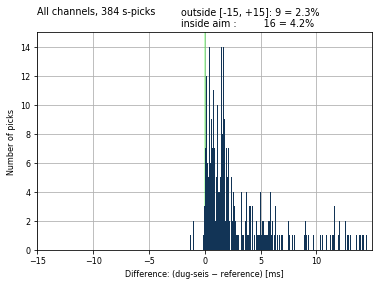

In [23]:
def channel_diffs(n):
    return [li[n] for li in merged['diffs'] if li[n] is not None]


dir = f'/home/1/dev/proj/dugseis/devel/processing/s-wave/plotting/gmug/histograms/{thr_on_str}'
diffs_all = []
pick_type = 's'

# radius = 0.2
# tickslist = [i / 100 for i in range(-20, 20, 5)]

# radius = 4
# tickslist = range(-radius, radius, 2)

radius = 15
tickslist = range(-radius, radius, 5)

if 1:
    for ch in range(12):
        diffs = channel_diffs(ch)
        diffs_all += diffs
        ds_picker_histogram.plot_exec(
            values=diffs,
            title=f'Channel {ch + 1}, {len(diffs)} {pick_type}-picks',
            filename=f'{dir}/{pick_type}_channel_r={radius}_{str(ch + 1).zfill(2)}.png',
            radius=radius,
            tickslist=tickslist,
        )


    ds_picker_histogram.plot_exec(
        values=diffs_all,
        title=f'All channels, {len(diffs_all)} {pick_type}-picks',
        filename=f'{dir}/{pick_type}_channel_r={radius}_all.png',
        radius=radius,
        tickslist=tickslist,
    )
